In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


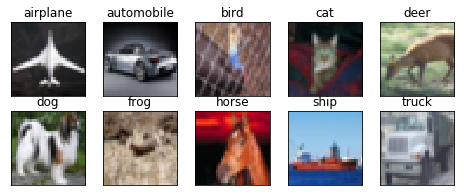

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
def AddSkipConnection(input_layer, residual_layers):
  input_shape = K.int_shape(input_layer)
  add_layers = [input_layer]
  for layer in residual_layers:
    residual_shape = K.int_shape(layer)
    stride_width = int(round(residual_shape[1]/ input_shape[1]))
    stride_height = int(round(residual_shape[2]/ input_shape[2]))
    filters = int(input_shape[3])
    equal_channels = input_shape[3] == residual_shape[3]

    sampled_layer = layer
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        sampled_layer = Convolution2D(
            filters=filters,
            kernel_size=(1, 1),
            strides=(stride_width, stride_height)
        )(layer)
    add_layers.append(sampled_layer)
  return Add()(add_layers)



In [0]:
def SepConv2D(filters, kernel, input):
  sep =  SeparableConv2D(filters, kernel, padding='same')(input)
  act = Activation('relu')(sep)
  bat = BatchNormalization()(act)
  return Dropout(0.1)(bat)

def Con2D(filters, kernel, input):
  con = Convolution2D(filters, kernel, padding='same')(input)
  act = Activation('relu')(con)
  bat = BatchNormalization()(act)
  return Dropout(0.1)(bat)

In [0]:
# Define the model
from keras.layers import Input
from keras.layers import Add, AveragePooling2D, BatchNormalization, Dropout, Activation
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras import backend as K
  

inp = Input(shape=(32,32,3))

sep_1 = SepConv2D(32, 5, inp)

con_1 = Con2D(32, 5, sep_1)

con_2 = Con2D(32, 5, con_1)

group_1 = AddSkipConnection(con_2, [sep_1])
sep_2 = SepConv2D(32, 5, group_1)

group_2 = AddSkipConnection(sep_2, [sep_1])
max_1 = MaxPooling2D(pool_size=(2, 2))(group_2)

sep_3 = SepConv2D(32, 3, max_1)

group_3 = AddSkipConnection(sep_3, [sep_1, sep_2])
con_3 = Con2D(32, 5, group_3)

group_5 = AddSkipConnection(con_3, [con_2, sep_2, sep_3])
sep_4 = SepConv2D(32, 3, group_5)

group_6 = AddSkipConnection(sep_4, [con_3, sep_2, sep_1, sep_3, con_2])
sep_5 = SepConv2D(32, 5, group_6)

group_7 = AddSkipConnection(sep_5, [sep_4, sep_2, sep_3, sep_1])
max_2 = MaxPooling2D(pool_size=(2, 2))(group_7)

group_8 = AddSkipConnection(max_2, [con_3])
con_4 = Con2D(32, 5, group_8)

group_9 = AddSkipConnection(con_4, [sep_2, sep_4, con_1])
sep_6 = SepConv2D(32, 5, group_9)

group_10 = AddSkipConnection(sep_6, [con_1,con_2,con_4,sep_3])
con_5 = Con2D(32, 3, group_10)


group_11 = AddSkipConnection(con_5, [sep_1, con_2,sep_4,sep_6,sep_3,sep_2])
sep_7 = SepConv2D(32, 5, group_11)

group_12 = AddSkipConnection(sep_7, [sep_6, sep_4, sep_2])
point = Convolution2D(10,8)(group_12)
flatten1 = Flatten()(point)

output = Activation('softmax')(flatten1)

model = Model(inputs=inp, outputs=output)
model.summary()

#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_59 (SeparableC (None, 32, 32, 32)   203         input_11[0][0]                   
__________________________________________________________________________________________________
activation_81 (Activation)      (None, 32, 32, 32)   0           separable_conv2d_59[0][0]        
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 32, 32, 32)   128         activation_81[0][0]         

In [0]:
from keras.callbacks import LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64
EPOCHS = 100

datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(train_features)

train_flow = datagen.flow(train_features, train_labels, batch_size=BATCH_SIZE)
valid_flow = datagen.flow(test_features, test_labels, batch_size=BATCH_SIZE, shuffle=False)

STEP_SIZE_TRAIN=train_flow.n//train_flow.batch_size
STEP_SIZE_VALID=valid_flow.n//valid_flow.batch_size

history = model.fit_generator(train_flow,
                    epochs=EPOCHS,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_flow,
                    validation_steps=STEP_SIZE_VALID)

Epoch 1/100
781/781 [==============================] - 42s 54ms/step - loss: 1.7724 - acc: 0.4199 - val_loss: 1.4937 - val_acc: 0.5145
Epoch 2/100
781/781 [==============================] - 33s 43ms/step - loss: 1.2350 - acc: 0.5673 - val_loss: 1.0752 - val_acc: 0.6214
Epoch 3/100
781/781 [==============================] - 33s 43ms/step - loss: 1.0379 - acc: 0.6364 - val_loss: 1.0552 - val_acc: 0.6380
Epoch 4/100
781/781 [==============================] - 34s 43ms/step - loss: 0.8968 - acc: 0.6891 - val_loss: 0.8887 - val_acc: 0.6937
Epoch 5/100
781/781 [==============================] - 34s 43ms/step - loss: 0.8132 - acc: 0.7168 - val_loss: 0.8652 - val_acc: 0.7053
Epoch 6/100
781/781 [==============================] - 34s 43ms/step - loss: 0.7495 - acc: 0.7379 - val_loss: 0.8735 - val_acc: 0.6976
Epoch 7/100
781/781 [==============================] - 34s 43ms/step - loss: 0.6959 - acc: 0.7559 - val_loss: 0.7704 - val_acc: 0.7400
Epoch 8/100
781/781 [==============================] - 

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and Validation Accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs,val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
#Train and Validation Loss
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs,val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Conclusion


## Accuracy achieved 88.97 @ Epoch 85 against base accuracy 83.51 @ Epoch 90
Compare to mnist network cifar-10 dataset is complex and needs to learn more complex features therefore i have build a network with more layers and based on inputs from session 6 i used border_mode equal to same which is nothing but padding = same which helped me to build more layers and after finalizing my network i experimented with 18 lakh parameters and my accuracy was arround 89 and after reducing the parameters slowly i was achieve same accuracy with aroung 5 lakh parameters and with the help of batch normalization and dropout and image augmentation i was able to reduce over fitting 

Also tried to use regularization but it increased my overfitting was not able to understand why?